In [29]:
import os
import sys
import pickle
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

from plot_settings import define_plot_settings

project_dir = os.path.abspath('..')
print(f"Project directory: {project_dir}")
sys.path.append(os.path.join(project_dir))

Project directory: /zhome/19/d/137388/github/DeepLearning_PAINN


### Benchmark results (from PaiNN paper)

Here, the benchmark results from the PaiNN paper are restated:

In [30]:
test_mae_benchmark = np.array([[0.012, 0.045, 27.6, 20.4, 45.7, 0.066, 1.28, 5.85, 5.83, 5.98, 7.35, 0.024]])
target_names = ['mu', 'alpha', 'eps_HOMO', 'eps_LUMO', 'deps', 'R2', 'ZPVE', 'U0', 'U', 'H', 'G','cv']
df = pd.DataFrame(data=test_mae_benchmark, columns=target_names)
df.index=['Reference']

## Training history

Load training history data

In [31]:
def load_all_results(parameter, values, relative_paths):
    data = {}
    res_all = {}

    # Ensure relative_paths is a list, even if a single string is passed
    if isinstance(relative_paths, str):
        relative_paths = [relative_paths]

    for relative_path in relative_paths:
        results_path = f"{project_dir}/{relative_path}"
        
        for val in values:
            format_val = format(val, 'f').rstrip('0')
            for dirpath, dirnames, filenames in os.walk(results_path):
                
                if (f"{parameter}_{format_val}") in dirpath:
                    for file in sorted(filenames):
                        if ".pickle" in file:
                            with open(f"{dirpath}/{file}", 'rb') as pf:
                                p = pickle.load(pf)
                                res = p

                            res[parameter] = val
                            res_all[f"{parameter}_{val}"] = res

    return res_all

# Example usage
relative_paths = ['runs/train/SAM']
parameter = 'rho'
target = 'U0' 
#values = [0.00048,0.00053,0.00058,0.00064,0.00069,0.00074,0.00079,0.00084,0.00090,0.00095,0.001]
values_sam = [0.000001,0.000005,0.00001,0.00005,0.0001,0.0005,0.001]
res_all_sam = load_all_results(parameter, values_sam, relative_paths)

print(res_all_sam.keys())
res_all_sam['rho_1e-06'].keys()

dict_keys(['rho_1e-06', 'rho_5e-06', 'rho_1e-05', 'rho_5e-05', 'rho_0.0001', 'rho_0.0005', 'rho_0.001'])


dict_keys(['train_loss', 'val_loss', 'train_MAE', 'val_MAE', 'lr', 'epoch', 'test_MAE', 'val_loss_smoothed', 'rho'])

Print table to compare with benchmark

In [32]:
# Example usage
#relative_paths = ['runs/train/2024-12-02', 'runs/train/2024-12-03']
relative_paths = ['runs/train/ASAM']
parameter = 'rho'
target = 'U0'
#values = [0.00048,0.00053,0.00058,0.00064,0.00069,0.00074,0.00079,0.00084,0.00090,0.00095,0.001]
values_asam = [0.00001,0.00005,0.0001,0.0005,0.001]
res_all_asam = load_all_results(parameter, values_asam, relative_paths)

print(res_all_asam.keys())
res_all_asam['rho_0.0001'].keys()

dict_keys(['rho_1e-05', 'rho_5e-05', 'rho_0.0001', 'rho_0.0005', 'rho_0.001'])


dict_keys(['train_loss', 'val_loss', 'train_MAE', 'val_MAE', 'lr', 'epoch', 'test_MAE', 'val_loss_smoothed', 'rho'])

In [33]:
# Extract MAE values for different rho values
mae_values = [res_all_sam[f'rho_{val}']['test_MAE'][0] for val in values_sam]
min_val_loss_sam = [np.min(res_all_sam[f'rho_{val}']['val_MAE']) for val in values_sam]
min_val_loss_asam = [np.min(res_all_asam[f'rho_{val}']['val_MAE']) for val in values_asam]

# Calculate relative differences
relative_differences = [(mae - df.loc['Reference', target]) / df.loc['Reference', target] for mae in mae_values]
relative_differences_val = [(min_val - df.loc['Reference', target]) / df.loc['Reference', target] for min_val in min_val_loss_sam]

# Create a new DataFrame
rho_columns = [f'rho_{val}' for val in values_sam]
data = {
    target: [df.loc['Reference', target]] * len(values_sam),
    'MAE': mae_values,
    'Relative Difference': relative_differences,
    'Min val. MAE': min_val_loss_sam,
    'Relative Difference val.': relative_differences_val
}

df_mae = pd.DataFrame(data, index=rho_columns).T
df_mae


,rho_1e-06,rho_5e-06,rho_1e-05,rho_5e-05,rho_0.0001,rho_0.0005,rho_0.001
U0,5.850000,5.850000,5.850000,5.850000,5.850000,5.850000,5.850000
MAE,7.715552,8.028758,8.039262,9.056827,8.805157,9.363631,9.527098
Relative Difference,0.318898,0.372437,0.374233,0.548175,0.505155,0.600621,0.628564
Min val. MAE,7.379053,7.443457,7.390942,7.603198,7.715454,8.470898,8.620898
Relative Difference val.,0.261377,0.272386,0.263409,0.299692,0.318881,0.448017,0.473658


Plot training progress and results

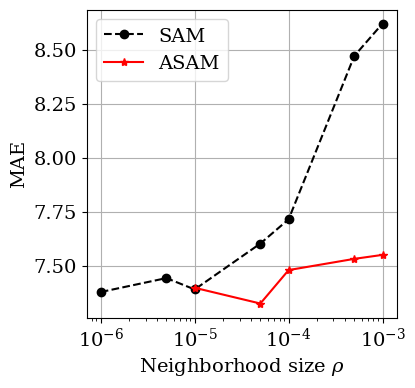

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
def plot_rho_vs_mae(rho,mae,**kwargs):
    ax.semilogx(rho, mae,**kwargs)

    
plot_rho_vs_mae(values_sam, min_val_loss_sam,marker='o',color='k',label='SAM',linestyle='--')
plot_rho_vs_mae(values_asam, min_val_loss_asam,marker='*',color='r',label='ASAM')

ax.set_ylabel('MAE')
ax.set_xlabel(r'Neighborhood size $\rho$')
ax.grid()
ax.legend()
plt.show()

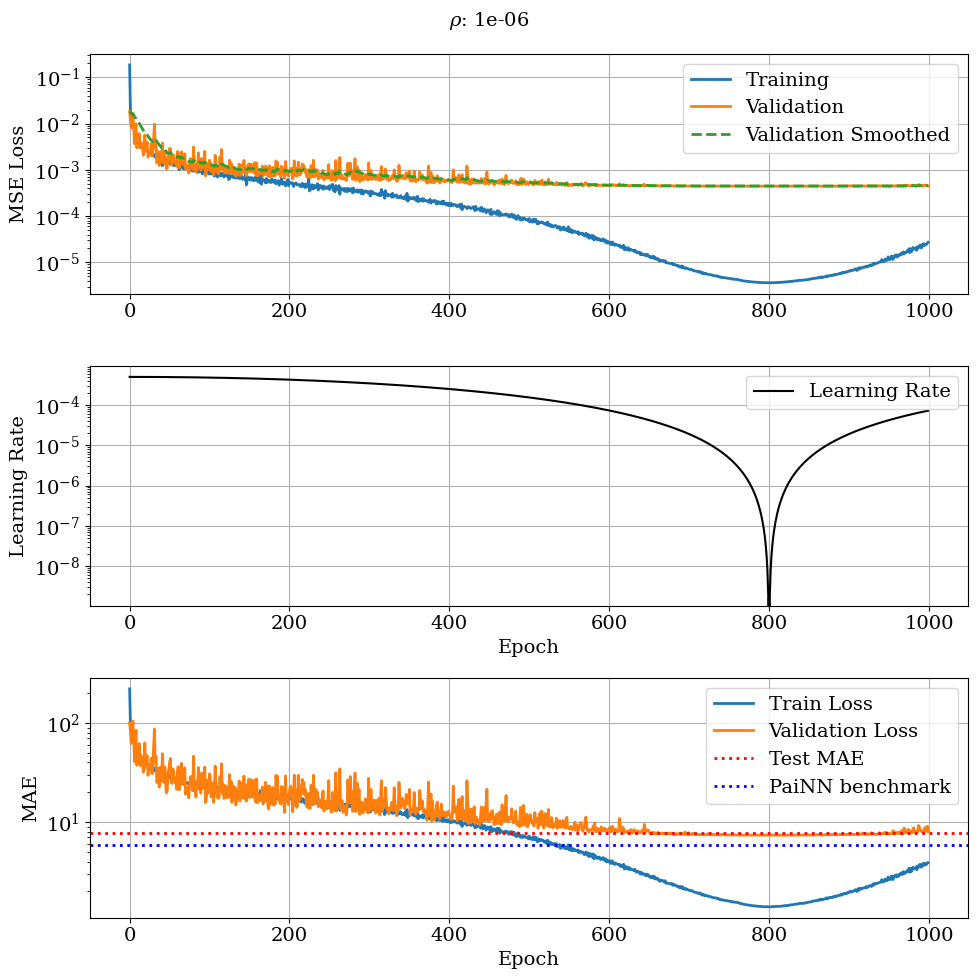

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), height_ratios=[1, 1.0, 1])

define_plot_settings(14)

def plot_training_progress(data):
    lw = 2.0
    # Plot primary y-axis (losses) on the first subplot
    ax1.semilogy(data['epoch'], data['train_loss'],'-', lw=lw, label='Training')
    ax1.semilogy(data['epoch'], data['val_loss'],'-', lw=lw, label='Validation')
    try:
        ax1.semilogy(data['epoch'], data['val_loss_smoothed'],'--', lw=lw, label='Validation Smoothed')
    except:
        pass
    # ax1.set_xlabel('Epoch')
    ax1.set_ylabel('MSE Loss')
    ax1.legend(loc='upper right')  # Legend for the first y-axis
    ax1.grid(True)

    # Plot secondary y-axis (learning rate) on the second subplot
    ax2.semilogy(data['epoch'], data['lr'], 'k-', label='Learning Rate')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate', color='k')
    ax2.tick_params(axis='y', labelcolor='k')
    ax2.legend(loc='upper right')  # Combine legends
    ax2.grid(True)

    plt.suptitle(f"$\\rho$: {data['rho']}")
    fig.tight_layout()

    # Plot primary y-axis (losses) on the first subplot
    ax3.semilogy(data['epoch'], data['train_MAE'],'-', lw=lw, label='Train Loss')
    ax3.semilogy(data['epoch'], data['val_MAE'],'-', lw=lw, label='Validation Loss')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('MAE')
        # Plot test MAE as a horizontal line
    test_mae = data['test_MAE'][0]  # Convert tensor to a scalar
    ax3.axhline(y=test_mae, color='r', linestyle=':', lw=lw, label='Test MAE')
    ax3.axhline(y=df[target]['Reference'], color='b', linestyle=':', lw=lw, label='PaiNN benchmark')
    ax3.legend(loc='upper right')  # Update legend to include Test MAE
    ax3.grid(True)
    fig.tight_layout()
    plt.show()

plot_training_progress(res_all_sam['rho_1e-06'])

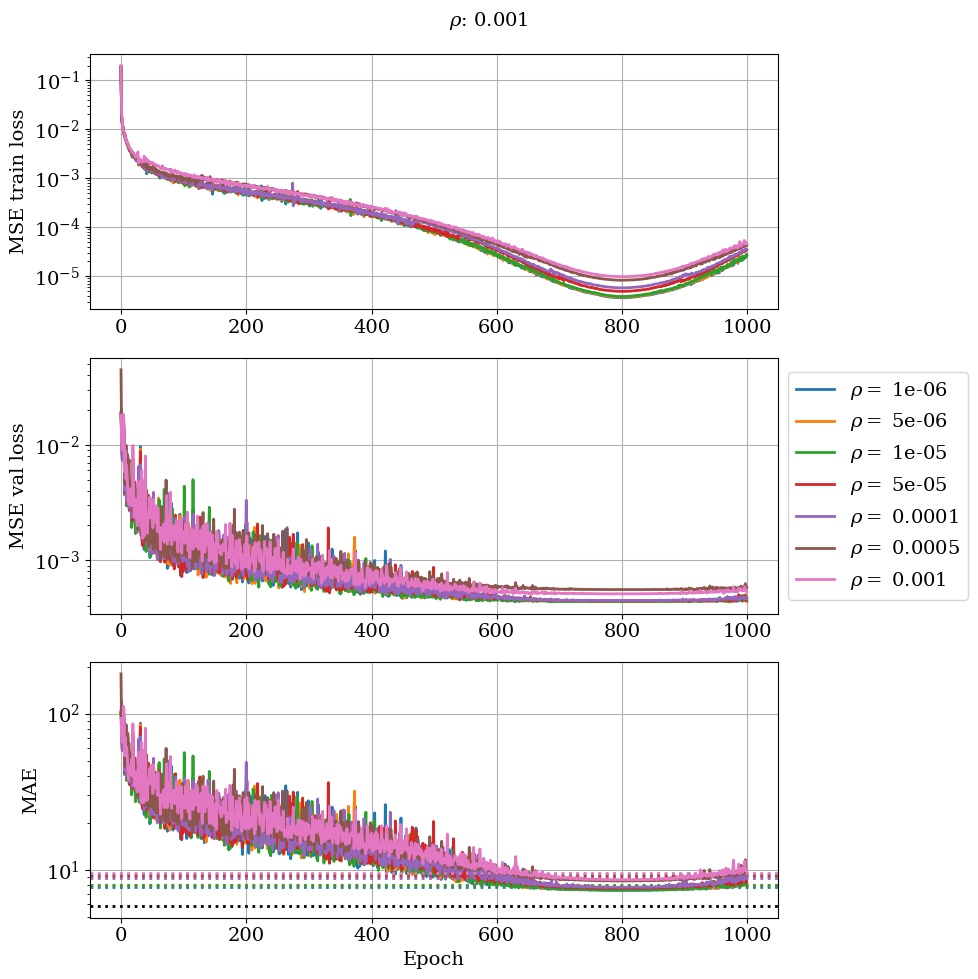

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10), height_ratios=[1, 1.0, 1])

define_plot_settings(14)

def plot_all(data):
    lw = 2.0
    # Plot primary y-axis (losses) on the first subplot
    for data in data.values():
        ax1.semilogy(data['epoch'], data['train_loss'],'-', lw=lw, label=f'$\\rho =$ {data["rho"]}')
        ax1.set_ylabel('MSE train loss')
        #ax1.legend(loc='upper right')  # Legend for the first y-axis
        ax1.grid(True)


        ax2.semilogy(data['epoch'], data['val_loss'],'-', lw=lw, label=f'$\\rho =$ {data["rho"]}')
        ax2.set_ylabel('MSE val loss')
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Legend for the first y-axis
        ax2.grid(True)
        
        # Plot primary y-axis (losses) on the first subplot
        ax3.semilogy(data['epoch'], data['val_MAE'],'-', lw=lw, label=f'$\\rho =$ {data["rho"]}')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('MAE')
            # Plot test MAE as a horizontal line
        test_mae = data['test_MAE'][0]  # Convert tensor to a scalar
        ax3.axhline(y=test_mae, color=ax3.get_lines()[-1].get_color(), linestyle=':', lw=lw, label='Test MAE')
    ax3.axhline(y=df[target]['Reference'], color='k', linestyle=':', lw=lw, label='PaiNN benchmark')
    # Put a legend to the right of the current axis
    #ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax3.grid(True)
        
    plt.suptitle(f"$\\rho$: {data['rho']}")
    fig.tight_layout()
    
    fig.tight_layout()
    plt.show()

plot_all(res_all_sam)

## Trained model 

Load trained model

In [37]:
# from src.models import model_loader
# results_path = f"{project_dir}/{relative_path}"
# checkpoint_path = f"{results_path}/model_checkpoint.pth"

# painn, metadata = model_loader.load_checkpoint(checkpoint_path);

# print(painn)
 

In [38]:
# Define the range
values = np.linspace(0.00001, 0.001, 20)

# Format the values into a string
output = f"({ ' '.join(f'{v:.5f}' for v in values) })"

# Print the result
print(output)


(0.00001 0.00006 0.00011 0.00017 0.00022 0.00027 0.00032 0.00037 0.00043 0.00048 0.00053 0.00058 0.00064 0.00069 0.00074 0.00079 0.00084 0.00090 0.00095 0.00100)
